In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import os

# Configuración
# Nota: Usamos '..' para subir de 'notebooks' a la raíz
DATA_DIR = os.path.join('..', 'data', 'raw')
IMG_SIZE = (180, 180)
BATCH_SIZE = 32

print(f"Usando TensorFlow: {tf.__version__}")
print("--- CARGANDO DATASETS ---")

try:
    # 1. Conjunto de ENTRENAMIENTO (80%)
    train_ds = tf.keras.utils.image_dataset_from_directory(
        DATA_DIR,
        validation_split=0.2,
        subset="training",
        seed=123,
        image_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        label_mode='binary'
    )

    # 2. Conjunto de VALIDACIÓN (20%)
    val_ds = tf.keras.utils.image_dataset_from_directory(
        DATA_DIR,
        validation_split=0.2,
        subset="validation",
        seed=123,
        image_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        label_mode='binary'
    )

    class_names = train_ds.class_names
    print(f"\nClases detectadas: {class_names}")

    # Optimización
    AUTOTUNE = tf.data.AUTOTUNE
    train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
    val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

except Exception as e:
    print(f"Error cargando datos: {e}")
    print("Verifica que la carpeta 'data/raw' tenga las subcarpetas correctas.")

Usando TensorFlow: 2.20.0
--- CARGANDO DATASETS ---
Found 300 files belonging to 2 classes.
Using 240 files for training.
Found 300 files belonging to 2 classes.
Using 60 files for validation.

Clases detectadas: ['Natalie Portman', 'Scarlett Johansson']


In [3]:
# --- DEFINICIÓN DEL MODELO ---
num_classes = 1

model = keras.Sequential([
    # 1. Aumento de Datos (Data Augmentation)
    layers.Input(shape=(180, 180, 3)),
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    
    # 2. Normalización (0-255 -> 0-1)
    layers.Rescaling(1./255),
    
    # 3. Convoluciones (Extraer características)
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    
    # 4. Clasificación
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_flip_1 (RandomFlip)      │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation_1               │ (None, 180, 180, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom_1 (RandomZoom)      │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 180, 180, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 90, 90, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     3,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,988,769 (15.22 MB)

 Trainable params: 3,988,769 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

In [4]:
epochs = 15
print(f"--- INICIANDO ENTRENAMIENTO ({epochs} Épocas) ---")

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

--- INICIANDO ENTRENAMIENTO (15 Épocas) ---
Epoch 1/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - accuracy: 0.5667 - loss: 0.7733 - val_accuracy: 0.6500 - val_loss: 0.6824
Epoch 2/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 0.6708 - loss: 0.6551 - val_accuracy: 0.6500 - val_loss: 0.6503
Epoch 3/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - accuracy: 0.6708 - loss: 0.6571 - val_accuracy: 0.6500 - val_loss: 0.6469
Epoch 4/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - accuracy: 0.6708 - loss: 0.6310 - val_accuracy: 0.6500 - val_loss: 0.6440
Epoch 5/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - accuracy: 0.6708 - loss: 0.6442 - val_accuracy: 0.6500 - val_loss: 0.6575
Epoch 6/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - accuracy: 0.6708 - loss: 0.6326 - val_accuracy: 0.6500 - val_loss: 0.6359
Epoch 7/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step - accuracy: 0.6708 - loss: 0.6451 - val_accuracy: 0.6500 - val_loss: 0.6240
Epoch 8/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - accuracy: 0.6708 - los

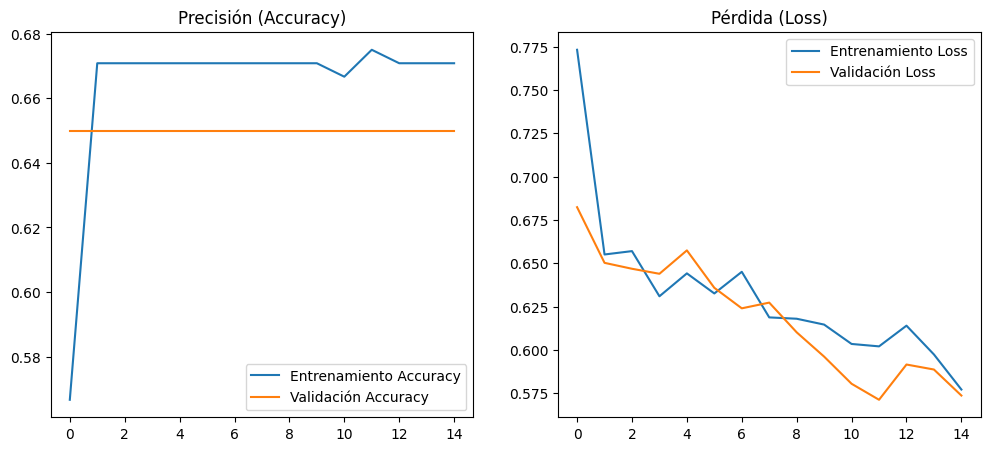

In [5]:
# Gráficas de Precisión y Pérdida
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 5))

# Gráfica de Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Entrenamiento Accuracy')
plt.plot(epochs_range, val_acc, label='Validación Accuracy')
plt.legend(loc='lower right')
plt.title('Precisión (Accuracy)')

# Gráfica de Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Entrenamiento Loss')
plt.plot(epochs_range, val_loss, label='Validación Loss')
plt.legend(loc='upper right')
plt.title('Pérdida (Loss)')
plt.show()

Iniciando re-entrenamiento con corrección de desbalance...
Epoch 1/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 0.6708 - loss: 0.8411 - val_accuracy: 0.6667 - val_loss: 0.5896
Epoch 2/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 0.7125 - loss: 0.8206 - val_accuracy: 0.7667 - val_loss: 0.5667
Epoch 3/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 0.6958 - loss: 0.8305 - val_accuracy: 0.7500 - val_loss: 0.5451
Epoch 4/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 0.7500 - loss: 0.7707 - val_accuracy: 0.6500 - val_loss: 0.5597
Epoch 5/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - accuracy: 0.7250 - loss: 0.7886 - val_accuracy: 0.7000 - val_loss: 0.5271
Epoch 6/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - accuracy: 0.7333 - loss: 0.7858 - val_accuracy: 0.7333 - val_loss: 0.5594
Epoch 7/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - accuracy: 0.7708 - loss: 0.7756 - val_accuracy: 0.6333 - val_loss: 0.5566
Epoch 8/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - accurac

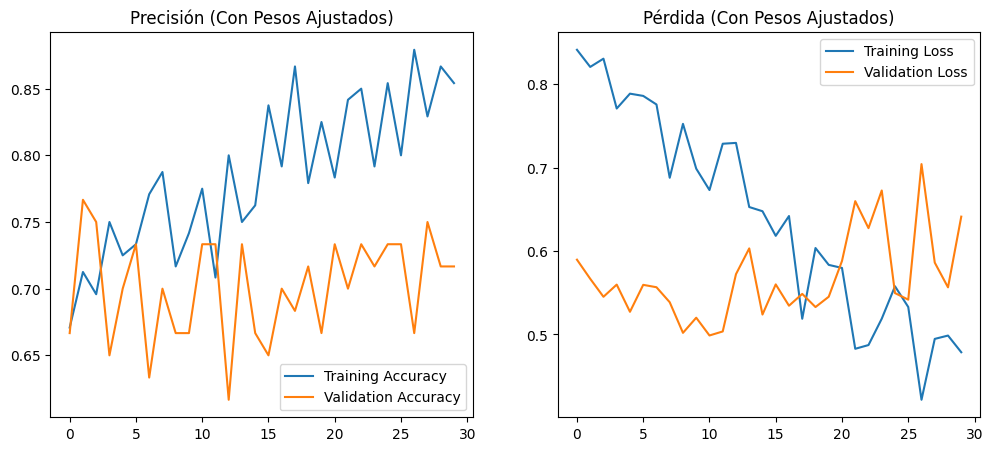

Mejor precisión obtenida: 76.67%


In [6]:
# --- CELDA 5: Re-entrenamiento con Pesos (Corrección del Balance) ---

# 1. Calcular pesos manualmente (Ya que no podemos usar sklearn)
# Tienes aprox 1/3 Natalie y 2/3 Scarlett.
# Hacemos que Natalie valga más (ej. 2.0) y Scarlett normal (1.0)
class_weights = {
    0: 2.0,  # Natalie Portman (Clase minoritaria: Pesa el doble)
    1: 1.0   # Scarlett Johansson (Clase mayoritaria: Pesa normal)
}

print("Iniciando re-entrenamiento con corrección de desbalance...")

# 2. Aumentamos las épocas a 30 para darle tiempo de aprender
epochs = 30

history_weighted = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    class_weight=class_weights # <--- Aquí está la magia
)

# --- VISUALIZACIÓN NUEVA ---
acc = history_weighted.history['accuracy']
val_acc = history_weighted.history['val_accuracy']
loss = history_weighted.history['loss']
val_loss = history_weighted.history['val_loss']
epochs_range = range(epochs)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Precisión (Con Pesos Ajustados)')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Pérdida (Con Pesos Ajustados)')
plt.show()

print(f"Mejor precisión obtenida: {max(val_acc)*100:.2f}%")

Generando Matriz de Confusión Correcta...


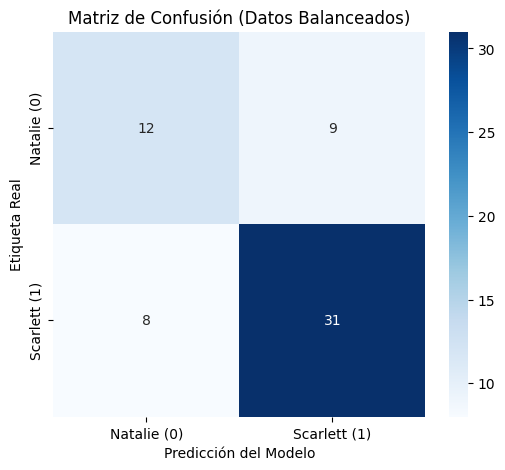

--- REPORTE FINAL ---
Total imágenes evaluadas: 60
Accuracy Real: 71.67%
Aciertos Natalie: 12
Aciertos Scarlett: 31
Falsos Positivos (Dijo Scarlett, era Natalie): 9
Falsos Negativos (Dijo Natalie, era Scarlett): 8


In [8]:
import seaborn as sns

print("Generando Matriz de Confusión Correcta...")

# Listas para acumular resultados
y_true_final = []
y_pred_final = []

# Iteramos sobre el dataset de validación ORIGINAL (el que sí tiene mezcla)
# Usamos 'unbatch()' para procesar imagen por imagen y asegurar el orden
for image, label in val_ds.unbatch():
    # 1. Guardar la etiqueta real
    y_true_final.append(label.numpy())
    
    # 2. Hacer la predicción
    # Expandimos dimensiones porque el modelo espera un lote (1, 180, 180, 3)
    img_batch = tf.expand_dims(image, 0)
    prediction = model.predict(img_batch, verbose=0)
    
    # 3. Convertir probabilidad a clase (0 o 1)
    predicted_class = 1 if prediction > 0.5 else 0
    y_pred_final.append(predicted_class)

# --- Construir la Matriz ---
confusion_mtx = tf.math.confusion_matrix(y_true_final, y_pred_final)

# --- Visualizar ---
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_mtx, annot=True, fmt='g', cmap='Blues',
            xticklabels=['Natalie (0)', 'Scarlett (1)'],
            yticklabels=['Natalie (0)', 'Scarlett (1)'])
plt.xlabel('Predicción del Modelo')
plt.ylabel('Etiqueta Real')
plt.title('Matriz de Confusión (Datos Balanceados)')
plt.show()

# --- Métricas Finales ---
tp = confusion_mtx[1, 1].numpy()
tn = confusion_mtx[0, 0].numpy()
fp = confusion_mtx[0, 1].numpy()
fn = confusion_mtx[1, 0].numpy()

# Evitar división por cero
total = tp + tn + fp + fn
accuracy = (tp + tn) / total if total > 0 else 0

print(f"--- REPORTE FINAL ---")
print(f"Total imágenes evaluadas: {total}")
print(f"Accuracy Real: {accuracy*100:.2f}%")
print(f"Aciertos Natalie: {tn}")
print(f"Aciertos Scarlett: {tp}")
print(f"Falsos Positivos (Dijo Scarlett, era Natalie): {fp}")
print(f"Falsos Negativos (Dijo Natalie, era Scarlett): {fn}")

✅ Modelo guardado como 'clasificador_portman_johansson.keras'

📸 Imagen: 056_666b6673.jpg
👉 Es NATALIE PORTMAN (83.60% seguridad)


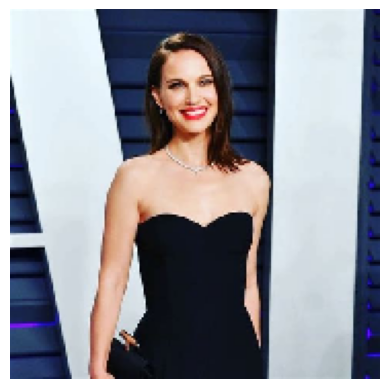

In [9]:
# --- CELDA 7: Guardado y Prueba Final ---
import numpy as np
from tensorflow.keras.preprocessing import image

# 1. Guardar el modelo en disco
model.save('clasificador_portman_johansson.keras')
print("✅ Modelo guardado como 'clasificador_portman_johansson.keras'")

# 2. Función para probar con CUALQUIER imagen (de internet o tuya)
def predecir_rostro(ruta_imagen):
    try:
        # Cargar y ajustar tamaño
        img = image.load_img(ruta_imagen, target_size=(180, 180))
        
        # Convertir a array y añadir dimensión de lote
        img_array = image.img_to_array(img)
        img_batch = np.expand_dims(img_array, axis=0)
        
        # Normalizar (igual que en el entrenamiento)
        # OJO: Si tu modelo tiene capa Rescaling interna (lo cual tiene), 
        # no normalizamos aquí manualmente.
        
        # Predecir
        prediction = model.predict(img_batch, verbose=0)
        score = float(prediction[0][0])
        
        print(f"\n📸 Imagen: {os.path.basename(ruta_imagen)}")
        if score > 0.5:
            confidence = (score) * 100
            print(f"👉 Es SCARLETT JOHANSSON ({confidence:.2f}% seguridad)")
        else:
            confidence = (1 - score) * 100
            print(f"👉 Es NATALIE PORTMAN ({confidence:.2f}% seguridad)")
            
        plt.imshow(img)
        plt.axis('off')
        plt.show()
        
    except Exception as e:
        print(f"Error cargando imagen: {e}")

# --- PRUEBA AUTOMÁTICA ---
# Vamos a tomar una foto real del set de validación para probar
import random
test_folder = os.path.join(DATA_DIR, 'Natalie Portman')
if os.path.exists(test_folder):
    random_img = random.choice(os.listdir(test_folder))
    img_path = os.path.join(test_folder, random_img)
    predecir_rostro(img_path)